# Geometric operations

**Credit**
[Vuokko Heikinheimo, Henrikki Tenkanen](https://automating-gis-processes.github.io/)  
Department of Geosciences & Geography, University of Helsinki  

## Overlay analysis

In this tutorial, the aim is to make an overlay analysis where we create a new layer based on geometries from a dataset that `intersect` with geometries of another layer. As our test case, we will select Polygon grid cells from `TravelTimes_to_5975375_RailwayStation_Helsinki.shp` that intersects with municipality borders of Helsinki found in `Helsinki_borders.shp`.

Typical overlay operations are (source: [QGIS docs](https://docs.qgis.org/2.8/en/docs/gentle_gis_introduction/vector_spatial_analysis_buffers.html#more-spatial-analysis-tools)):
![](img/overlay_operations.png)

In [1]:
import os

import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.speedups

In [3]:
# File paths
border_fp = ["..", "data", "Helsinki_borders", "Helsinki_borders.shp"]
grid_fp = ["..", "data", "Travel_times", "TravelTimes_to_5975375_RailwayStation.shp"]

border_file =os.path.join(*border_fp) 
grid_file = os.path.join(*grid_fp)

# Read files
borders = gpd.read_file(border_file)
grid = gpd.read_file(grid_file)

Let's do a quick overlay visualization of the two layers:

<AxesSubplot:>

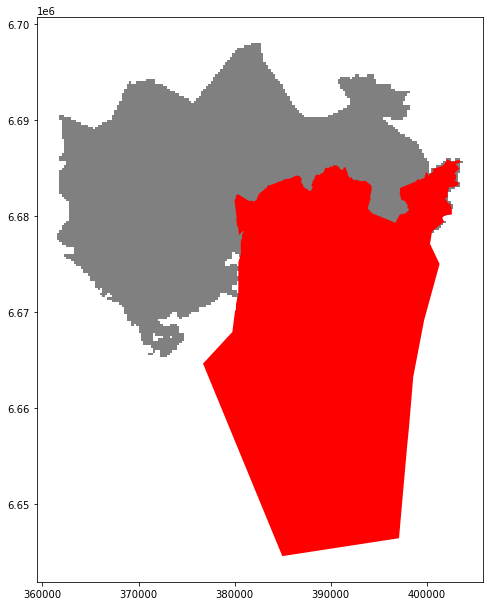

In [24]:
# Plot the layers
ax = grid.plot(facecolor='grey', figsize=(8, 12))
borders.plot(ax=ax, facecolor="red")



Here the grey area is the Travel Time Matrix - a data set that contains  13231 grid squares (13231 rows of data) that covers the Helsinki region, and the blue area represents the municipality of Helsinki. Our goal is to conduct an overlay analysis and select the geometries from the grid polygon layer that intersect with the Helsinki municipality polygon.

When conducting overlay analysis, it is important to first check that the CRS of the layers match. The overlay visualization indicates that everything should be ok (the layers are plotted nicely on top of each other). However, let's still check if the crs match using Python:

In [5]:
# Check the crs of the municipality polygon
borders.crs

<Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland - onshore and offshore.
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
# Ensure that the CRS matches, if not raise an AssertionError
assert borders.crs == grid.crs, "CRS do not match"

Indeed, they do. We are now ready to conduct an overlay analysis between these layers. 

We will create a new layer based on grid polygons that `intersect` with our Helsinki layer. We can use a function called `overlay()` to conduct the overlay analysis that takes as an input 1) first GeoDataFrame, 2) second GeoDataFrame, and 3) parameter `how` that can be used to control how the overlay analysis is conducted (possible values are `'intersection'`, `'union'`, `'symmetric_difference'`, `'difference'`, and `'identity'`):

In [8]:
intersection = gpd.overlay(grid, borders, how="intersection")

Let's plot our data and see what we have:

<AxesSubplot:>

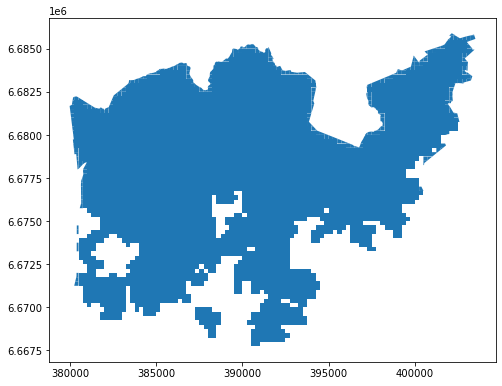

In [9]:
# Plot intersection
intersection.plot(figsize=(8,10))

As a result, we now have only those grid cells that intersect with the Helsinki borders. If you look closely, you can also observe that **the grid cells are clipped based on the boundary.**

- Whatabout the data attributes? Let's see what we have:


In [10]:
# Inspect the data
intersection.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry
0,29476,41,29483,46,5876274,29990,76,95,24984,77,99,5975375,25532,365,27517366,Helsinki,Helsingfors,091,"POLYGON ((402024.224 6685750.000, 402003.328 6..."
1,29456,41,29462,46,5876275,29866,74,95,24860,75,93,5975375,25408,363,27517366,Helsinki,Helsingfors,091,"POLYGON ((402250.000 6685750.000, 402250.000 6..."
2,36772,50,36778,56,5876278,33541,116,137,44265,130,146,5975375,31110,444,27517366,Helsinki,Helsingfors,091,"POLYGON ((403148.515 6685750.000, 403243.781 6..."
3,36898,49,36904,56,5876279,33720,119,141,44444,132,155,5975375,31289,447,27517366,Helsinki,Helsingfors,091,"POLYGON ((403250.000 6685750.000, 403250.000 6..."
4,29411,40,29418,44,5878128,29944,75,95,24938,76,99,5975375,25486,364,27517366,Helsinki,Helsingfors,091,"POLYGON ((401900.425 6685500.000, 402000.000 6..."


As we can see, due to the overlay analysis, the dataset contains the attributes from both input layers.

Let's save our result grid as a GeoJSON file that is commonly used file format nowadays for storing spatial data.

In [11]:
# Output filepath
outfp = ["..", "data", "TravelTimes_to_5975375_RailwayStation_Helsinki.geojson"]
out_file = os.path.join(*outfp)

# Save results. Use GeoJSON driver
intersection.to_file(out_file, driver='GeoJSON')

There are many more examples for different types of overlay analysis in [Geopandas documentation](http://geopandas.org/set_operations.html) where you can go and learn more.

## Aggregating data

Data aggregation refers to a process where we combine data into groups. When doing spatial data aggregation, we merge the geometries together into coarser units (based on some attribute), and can also calculate summary statistics for these combined geometries from the original, more detailed values. For example, suppose that we are interested in studying continents, but we only have country-level data like the country dataset. If we aggregate the data by continent, we would convert the country-level data into a continent-level dataset.

In this tutorial, we will aggregate our travel time data by car travel times (column `car_r_t`), i.e. the grid cells that have the same travel time to Railway Station will be merged together.

- For doing the aggregation we will use a function called `dissolve()` that takes as input the column that will be used for conducting the aggregation:


In [12]:
# Conduct the aggregation
dissolved = intersection.dissolve(by="car_r_t")

# What did we get
dissolved.head()

,geometry,car_m_d,car_m_t,car_r_d,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE
car_r_t,,,,,,,,,,,,,,,,,,
-1,"MULTIPOLYGON (((384500.000 6670000.000, 384500...",-1,-1,-1,5913094,-1,-1,-1,-1,-1,-1,-1,-1,-1,27517366,Helsinki,Helsingfors,091
0,"POLYGON ((385750.000 6672000.000, 385750.000 6...",0,0,0,5975375,0,0,0,0,0,0,5975375,0,0,27517366,Helsinki,Helsingfors,091
7,"POLYGON ((386000.000 6672250.000, 386000.000 6...",1051,7,1051,5973739,617,5,6,617,5,6,5975375,448,6,27517366,Helsinki,Helsingfors,091
8,"MULTIPOLYGON (((386000.000 6671500.000, 385750...",1286,8,1286,5973736,706,10,10,706,10,10,5975375,706,10,27517366,Helsinki,Helsingfors,091
9,"MULTIPOLYGON (((386000.000 6671250.000, 385750...",1871,9,1871,5970457,1384,11,13,1394,11,12,5975375,1249,18,27517366,Helsinki,Helsingfors,091


- Let's compare the number of cells in the layers before and after the aggregation:

In [13]:
print('Rows in original intersection GeoDataFrame:', len(intersection))
print('Rows in dissolved layer:', len(dissolved))

Rows in original intersection GeoDataFrame: 3826
Rows in dissolved layer: 51


Indeed the number of rows in our data has decreased and the Polygons were merged together.

What actually happened here? Let's take a closer look. 

- Let's see what columns we have now in our GeoDataFrame:

In [14]:
dissolved.columns

Index(['geometry', 'car_m_d', 'car_m_t', 'car_r_d', 'from_id', 'pt_m_d',
       'pt_m_t', 'pt_m_tt', 'pt_r_d', 'pt_r_t', 'pt_r_tt', 'to_id', 'walk_d',
       'walk_t', 'GML_ID', 'NAMEFIN', 'NAMESWE', 'NATCODE'],
      dtype='object')

As we can see, the column that we used for conducting the aggregation (`car_r_t`) can not be found from the columns list anymore. What happened to it?

- Let's take a look at the indices of our GeoDataFrame:

In [15]:
dissolved.index

Int64Index([-1,  0,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
            22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
            39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
            56],
           dtype='int64', name='car_r_t')

Aha! Well now we understand where our column went. It is now used as index in our `dissolved` GeoDataFrame. 

- Now, we can for example select only such geometries from the layer that are for example exactly 15 minutes away from the Helsinki Railway Station:

In [16]:
# Select only geometries that are within 15 minutes away
dissolved.iloc[15]

geometry    (POLYGON ((388250.0001354316 6668750.000042891...
car_m_d                                                 12035
car_m_t                                                    18
car_r_d                                                 11997
from_id                                               5903886
pt_m_d                                                  11568
pt_m_t                                                     30
pt_m_tt                                                    36
pt_r_d                                                  11568
pt_r_t                                                     34
pt_r_tt                                                    37
to_id                                                 5975375
walk_d                                                  11638
walk_t                                                    166
GML_ID                                               27517366
NAMEFIN                                              Helsinki
NAMESWE 

In [18]:
# See the data type
type(dissolved.iloc[15])

pandas.core.series.Series

In [19]:
dissolved.iloc[15].head()

geometry    (POLYGON ((388250.0001354316 6668750.000042891...
car_m_d                                                 12035
car_m_t                                                    18
car_r_d                                                 11997
from_id                                               5903886
Name: 20, dtype: object

As we can see, as a result, we have now a Pandas `Series` object containing basically one row from our original aggregated GeoDataFrame.

Let's also visualize those 15 minute grid cells.

- First, we need to convert the selected row back to a GeoDataFrame:

In [21]:
# Create a GeoDataFrame
selection = gpd.GeoDataFrame([dissolved.iloc[15]], crs=dissolved.crs)

- Plot the selection on top of the entire grid:

<AxesSubplot:>

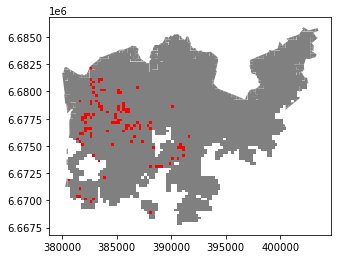

In [23]:
# Plot all the grid cells, and the grid cells that are 15 minutes a way from the Railway Station

ax = dissolved.plot(facecolor='gray')
selection.plot(ax=ax, facecolor='red')

## Simplifying geometries

Sometimes it might be useful to be able to simplify geometries. This could be something to consider for example when you have very detailed spatial features that cover the whole world. If you make a map that covers the whole world, it is unnecessary to have really detailed geometries because it is simply impossible to see those small details from your map. Furthermore, it takes a long time to actually render a large quantity of features into a map. Here, we will see how it is possible to simplify geometric features in Python.

As an example we will use data representing the Amazon river in South America, and simplify it's geometries.

- Let's first read the data and see how the river looks like:

PROJCS["Mercator_2SP",GEOGCS["GCS_GRS 1980(IUGG, 1980)",DATUM["D_unknown",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Unknown",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mercator_2SP"],PARAMETER["standard_parallel_1",-2],PARAMETER["central_meridian",-43],PARAMETER["false_easting",5000000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


<AxesSubplot:>

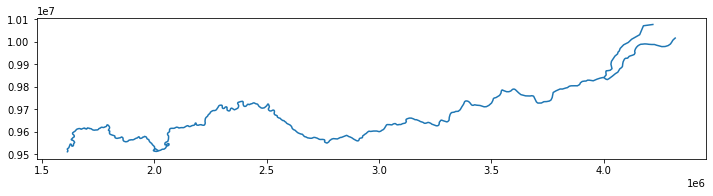

In [27]:
# File path
fp = ["..", "data", "amazon", "Amazon_river.shp"]
amazon_file = os.path.join(*fp)

data = gpd.read_file(amazon_file)

# Print crs
print(data.crs)

# Plot the river
data.plot(figsize=(12,6))

The LineString that is presented here is quite detailed, so let's see how we can generalize them a bit. As we can see from the coordinate reference system, the data is projected in a metric system using [Mercator projection based on SIRGAS datum](http://spatialreference.org/ref/sr-org/7868/). 

- Generalization can be done easily by using a Shapely function called `.simplify()`. The `tolerance` parameter can be used to adjusts how much geometries should be generalized. **The tolerance value is tied to the coordinate system of the geometries**. Hence, the value we pass here is 20 000 **meters** (20 kilometers).



In [40]:
# Generalize geometry
data["geom_gen"] = data.simplify(tolerance=20000)

# Set geometry to be our new simlified geometry
data.set_geometry("geom_gen")


,bbox_east,bbox_north,bbox_south,bbox_west,place_name,geometry,geom_gen
0,-49.10927,0.70653,-4.44219,-73.450126,"Rio Amazonas, Microrregião de Manaus, Mesorreg...","MULTILINESTRING ((1612358.589 9508606.173, 161...","MULTILINESTRING ((1612358.589 9508606.173, 165..."


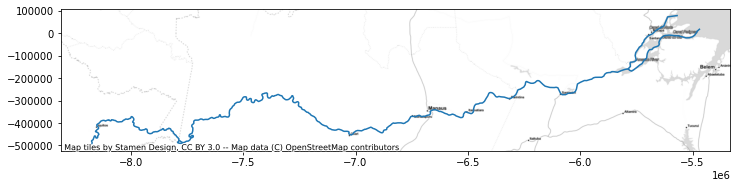

In [45]:
# Plot it
ax = data.to_crs(epsg=3857).plot(figsize=(12,6))
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

Nice! As a result, now we have simplified our LineString quite significantly as we can see from the map.